In [72]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV


In [68]:
mohs = pd.read_csv('mohs_patients_10000.csv')

for i in mohs.dtypes.index:
    if mohs.dtypes[i] == 'object':
        mohs[i] = mohs[i].astype('category')

mohs['Complexity'] = mohs['Complexity'].map({'Simple': 0, 'Complex': 1})

,PatientID,Complexity,TumorType,Location,TumorDiameter_mm,HistologicSubtype,SpeaksEnglish,Age,Immunosuppressed
0,Patient_00001,0,Basal Cell Carcinoma,Ear,5.5,Basosquamous,English,62,No
1,Patient_00002,0,Melanoma in situ,Forehead,8.8,Infiltrative,English,89,No
2,Patient_00003,1,Squamous Cell Carcinoma,Forehead,11.4,Desmoplastic,Non-English,50,No
3,Patient_00004,0,Melanoma in situ,Forehead,4.1,Desmoplastic,English,45,No
4,Patient_00005,0,Basal Cell Carcinoma,Ear,3.0,Superficial,English,66,No
...,...,...,...,...,...,...,...,...,...
9995,Patient_09996,0,Basal Cell Carcinoma,Forehead,7.4,Infiltrative,English,44,No
9996,Patient_09997,1,Basal Cell Carcinoma,Nose,9.3,Keratoacanthoma-like,English,82,No
9997,Patient_09998,0,Basal Cell Carcinoma,Neck,3.4,Keratoacanthoma-like,English,85,No
9998,Patient_09999,0,Basal Cell Carcinoma,Eyelid,5.1,Morpheaform,Non-English,56,Yes


In [69]:
X = mohs.drop(columns=['Complexity','PatientID'], axis=1)
y = mohs['Complexity']

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
xgb_train = xgb.DMatrix(x_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(x_test, y_test, enable_categorical=True)

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}
n=50
model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                         enable_categorical=True)

# Define parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [1,2,3,4,5,6,7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use roc_auc as scoring metric
scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best AUC:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packa

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytre

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=7, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1, subsampl

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=2, subsample=1.

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=6, subsample=0.8; to

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=1, subsample=0.8; to

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=4, subsample=0.8;

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:55] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=2, subsample=

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=4, subsample=1.0; to

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=6, subsample=0.8; to

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=7, subsample=0.8; to

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:53:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-pa

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=7, n_jobs=None,
              num_parallel_tree=None, ...)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'TumorType'),
  Text(1, 0, 'Location'),
  Text(2, 0, 'TumorDiameter_mm'),
  Text(3, 0, 'HistologicSubtype'),
  Text(4, 0, 'Age'),
  Text(5, 0, 'Immunosuppressed')])

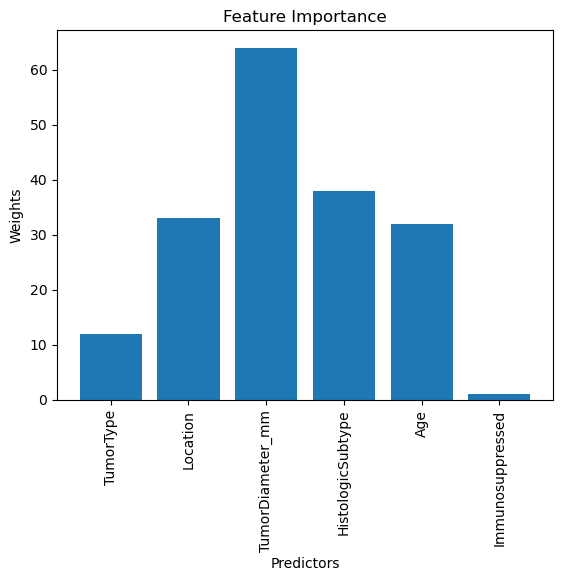

In [76]:
Predictors = best_model.get_booster().get_score(importance_type='weight').keys()
Weights = best_model.get_booster().get_score(importance_type='weight').values()

plt.bar(Predictors, Weights)
plt.xlabel('Predictors')
plt.ylabel('Weights')
plt.title('Feature Importance')
plt.xticks(rotation=90)

In [75]:
preds_proba = best_model.predict(x_test)  # probabilities from XGBoost
auc = roc_auc_score(y_test, preds_proba)
print('AUC of the model is:', auc)

AUC of the model is: 0.8215081820731087


In [84]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for training
dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)

# Set default parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}

# Run cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    nfold=5,
    metrics='auc',
    early_stopping_rounds=10,
    seed=42,
    verbose_eval=True
)

best_auc = cv_results['test-auc-mean'].max()
print(f"Cross-validation AUC: {best_auc:.4f}")

[0]	train-auc:0.90471+0.00214	test-auc:0.90195+0.00923
[1]	train-auc:0.90602+0.00180	test-auc:0.90351+0.00955
[2]	train-auc:0.90689+0.00309	test-auc:0.90399+0.00886
[3]	train-auc:0.90747+0.00297	test-auc:0.90469+0.00906
[4]	train-auc:0.90844+0.00241	test-auc:0.90558+0.00969
[5]	train-auc:0.90922+0.00218	test-auc:0.90637+0.00989
[6]	train-auc:0.91003+0.00259	test-auc:0.90610+0.00996
[7]	train-auc:0.91012+0.00255	test-auc:0.90619+0.00994
[8]	train-auc:0.91017+0.00255	test-auc:0.90614+0.00995
[9]	train-auc:0.91059+0.00302	test-auc:0.90622+0.00963
[10]	train-auc:0.91067+0.00301	test-auc:0.90605+0.00967
[11]	train-auc:0.91071+0.00308	test-auc:0.90618+0.00974
[12]	train-auc:0.91108+0.00282	test-auc:0.90658+0.01006
[13]	train-auc:0.91109+0.00285	test-auc:0.90655+0.01008
[14]	train-auc:0.91159+0.00322	test-auc:0.90629+0.01016
[15]	train-auc:0.91204+0.00388	test-auc:0.90620+0.01032
[16]	train-auc:0.91317+0.00367	test-auc:0.90740+0.01088
[17]	train-auc:0.91369+0.00373	test-auc:0.90715+0.01110
[1